In [38]:
!pip3 install pandas # Installing deps
!pip3 install numpy 
!pip3 install sklearn
!pip3 install torch

In [8]:
!pip3 install torch 
!pip3 install transformers

In [2]:
!pip3 install seaborn

In [2]:
import math 
import os
from pathlib import Path
import random
from tempfile import TemporaryDirectory
import time

import seaborn as sn

from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode
from transformers import DataCollatorWithPadding
from transformers import BertConfig, BertForSequenceClassification, PreTrainedTokenizerFast
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from tokenizers import normalizers
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import NFD, Lowercase, NFKC
from tokenizers import pre_tokenizers
from tokenizers.pre_tokenizers import Whitespace, ByteLevel
from tokenizers import Tokenizer, models, trainers
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score




/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from stats import array, epocs, training_loss, validation_loss # Results for analysis

In [33]:
# Learning weights
learning_rate = 1e-4
weight_decay = 1e-2
lr_scheduler_type = "logistic"

num_train_epochs = 5

train_batch_size = 32
eval_batch_size = 32
model_path = "/ethan/Documents/classes/BIO/working/model"

gradient_accumulation_steps=2
eval_accumulation_steps=2

warmup_steps = 0
n_classes = 6

adam_beta1 = 0.9 
adam_beta2 = 0.999
adam_epsilon = 1e-8
max_grad_norm = 1.0


In [7]:
class TransformerModel(nn.Module):

    def __init__(self, n_classes:int, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.classifier = nn.Linear(d_model, n_classes)
        
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.classifier.bias.data.zero_()
        self.classifier.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) #* math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        
        first_token_tensor = output[:, 0]
        classifier = self.classifier(first_token_tensor)
#         pooled_output = self.activation(pooled_output)
        return classifier

    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
print('cp')

cp


In [5]:
seed=83110
split = [0.8, 0.1, 0.1]


# Loads dataset
dataset = load_dataset("csv", data_files={'train': ["/ethan/Documents/classes/BIO/working/train.csv"],
                                          'val': ["/ethan/Documents/classes/BIO/working/val.csv"],
                                         'test': ["/ethan/Documents/classes/BIO/working/test.csv"],
                                         },
                      split=None)
data = pd.DataFrame(dataset) # Loads dataset into a dataframe

X_train, X_test, y_train, y_test = train_test_split(
    data['text'],
    data['label'],
    test_size=split[1],
    train_size=1-split[1],
    random_state=seed,
    shuffle=True,
    stratify=data['label'],
)

n_ratio = X_test.shape[0]/X_train.shape[0]

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=n_ratio,
    train_size=1-n_ratio,
    random_state=seed,
    shuffle=True,
    stratify=y_train,
)


FileNotFoundError: Unable to find '/ethan/Documents/classes/BIO/working/train.csv' at /

In [15]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()), end='\r')

    avg_loss = train_loss / (batch_idx+1)
    print('\nTraining set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


In [28]:
# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted')
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


In [32]:
model = TransformerModel(n_classes, vocab_size, max_length, num_attention_heads, hidden_size, num_hidden_layers, drop_out).to(device)

NameError: name 'vocab_size' is not defined

In [27]:
config = BertConfig(
    num_labels=n_classes,
    # mask_token_id = 4,
    bos_token_id = 1,                          
    sep_token_id = 2,                          
    #  pad_token_id = 3,
    eos_token_id = 2,

    max_position_embeddings = max_position_embeddings,

    hidden_size = hidden_size,                          
    num_hidden_layers = num_hidden_layers,                          
    num_attention_heads = num_attention_heads,                          
    intermediate_size = intermediate_size,

    hidden_act = 'gelu',
    hidden_dropout_prob = drop_out,
    attention_probs_dropout_prob = drop_out,

    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12, 

    vocab_size = vocab_size,

    use_cache = True,                          
    classifier_dropout = None,
    onnx_export = False)

NameError: name 'n_classes' is not defined

In [4]:
# Training model
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()), end='\r')

    avg_loss = train_loss / (batch_idx+1)
    print('\nTraining set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


[[33, 10, 1, 4, 2, 3], [3, 29, 6, 9, 1, 15], [0, 3, 26, 2, 0, 11], [0, 4, 0, 23, 0, 6], [0, 2, 10, 5, 25, 2], [0, 12, 1, 5, 8, 25]]


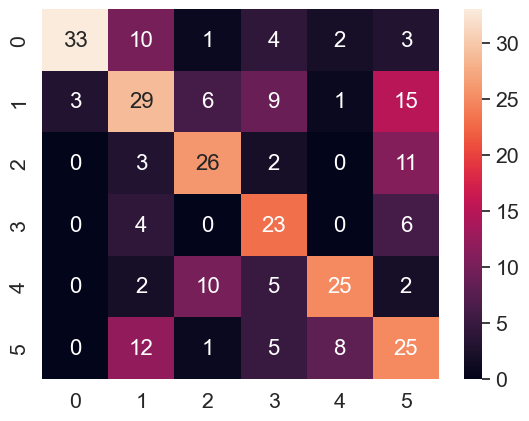

In [21]:
# Open txt files
print(array)
df_cm = pd.DataFrame(array, range(6), range(6))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

# Analysis

The features that were being set up are different features and attributes of the DNA sequence. 

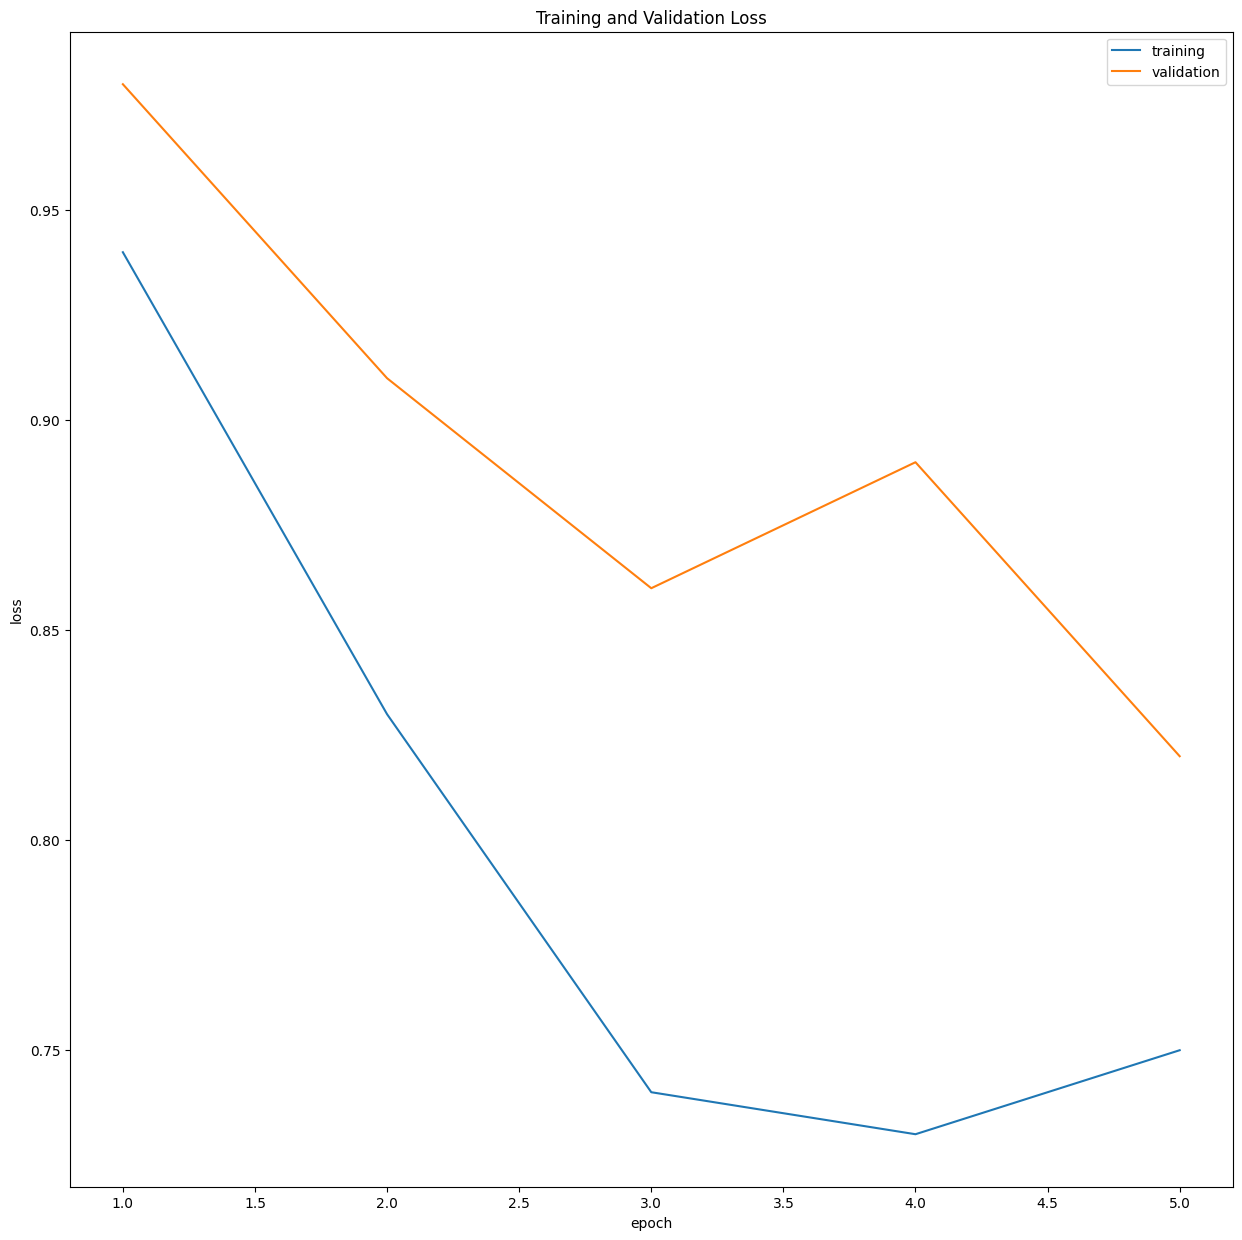

In [14]:
plt.figure(figsize=(15,15))
plt.plot(epocs, validation_loss)
plt.plot(epocs, training_loss)

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()